# Graph Metrics in fMRI data

In [1]:
## Import statements and load data
from __future__ import division
import numpy as np
import scipy
from scipy import io
from scipy import special as special
import scipy.stats as stats
from itertools import chain,combinations
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Loading Data 
dataC = scipy.io.loadmat("data/controls.mat")['controls'] #17, 116, 116
dataD = scipy.io.loadmat("data/depressed.mat")['depressed'] #16, 116, 116

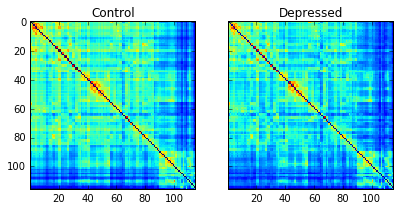

In [3]:
# Let's visualize these first
C_avgd = np.mean(dataC, 0)   #collapse across subjects
D_avgd = np.mean(dataD, 0)

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3), sharey=True)

axs[0].imshow(C_avgd, interpolation='nearest')
axs[0].set_title('Control')
#plt.show()
axs[1].set_title('Depressed')
axs[1].imshow(D_avgd, interpolation='nearest')
plt.show()

## Metric 1 - Characteristic Path Length

The *characteristic path length* is the average of the shortest distances between all vertices. We'll take all pairs of vertices, calculate the shortest distance, then average the collection that we obtain. Since correlation is an undirected connectivity measure (i.e. *Corr(x, y) = Corr(y, x)*), we can cut the number of distances we have to calculate by half. 

A network with a low CPL (usually) has a nice situation going with information transfer (distance is minimized between nodes). For correlation values, we'll have to take absolute values in order to make sure we're measuring a true "distance". So our pipeline looks like:

Correlation Matrices → Absolute Correlation → Distance Matrices → Characteristic Path Length

Food for thought: Can an excessively low CPL be bad? In a brain, what anatomical and information-theoretic considerations might counterbalance the benefits of low CPL? 

In [4]:
# Calculate characteristic path length

import scipy.sparse.csgraph as graphs

CPL_C = np.zeros(dataC.shape[0])
CPL_D = np.zeros(dataD.shape[0])

for subj in range(0, dataC.shape[0]):
    dist = graphs.shortest_path(np.abs(dataC[subj,:,:]), method = 'D')  #our connectivity measure can be negative
    CPL_C[subj] = np.nanmean(np.nanmean(np.where(dist!=0, dist, np.nan),1))
    
for subj in range(0, dataD.shape[0]):
    dist = graphs.shortest_path(np.abs(dataD[subj,:,:]), method = 'D')  
    CPL_D[subj] = np.nanmean(np.nanmean(np.where(dist!=0, dist, np.nan),1))

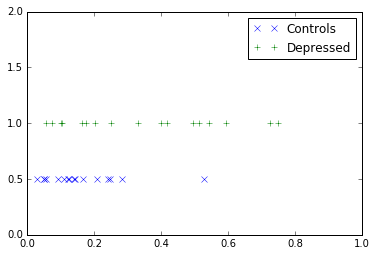

In [5]:
# Visualize our CPL measures between groups
plt.plot(CPL_D, len(CPL_D) * [0.5], "x", label = 'Controls')
plt.plot(CPL_C, len(CPL_C) * [1], "+", label = 'Depressed')
plt.axis([0, 1,0,2])
plt.legend()
plt.show()
# We'll test the group difference significance later...

## Metric 2 - Connected Components

Sometimes we may want to understand how many components the network can cleanly separate into (Ashton will cover the a quantification of "cleanly" later). In order to do this with our current data, we'll have to *threshold* our matrix by setting equal to 0 any values below a given threshold.

Some things to note about this process:
   * We assume functional connections weaker than our threshold are noise. 
   * Thresholding can make the data easier to work with or visualize.
   * Many analyses have pointed out that network structure can vary significantly under different thresholds.


Food for thought: What might be a principled way to choose a threshold? What network measures are robust to thresholding?

In [6]:
# Connected Components: Thresholding

bin_C = np.ones(dataC.shape)   # we'll have to store our adjacency matrices following binarization
bin_D = np.ones(dataD.shape)

thresh = 1.4                # our threshold; all values < epsilon will be assigned a 0
                             # abs(values) range from 0 to 2.9; mess with epsilon accordingly 

sub_threshold_indices = np.abs(dataC) < thresh
bin_C[sub_threshold_indices] = 0  

sub_threshold_indices = np.abs(dataD) < thresh
bin_D[sub_threshold_indices] = 0    

Now that we've thresholded our matrix, we can proceed with two approaches for computing connected components: the *depth-first search* algorithm and the *Laplacian*. The former is far more numerically stable and has a lower runtime but, for ~culture~, we'll also discuss the Laplacian. 

**Depth First Search**

Pick a node. We'll branch out from it by exploring all connected nodes (the "depth" in the name is because, as soon as we hit a new node, we'll explore down that avenue instead - visualizing this, we're exploring deep down a branch as opposed to checking all neighboring nodes first). We'll explore all connected nodes and note when we've visited a node. 

Now pick another node. If it's been visited, we move on. If not, we add +1 to our connected component count and then perform the above procedure. 

**Laplacian**

Refresher/dirty explanation: the *kernel* of a matrix is the set of all vectors x such that Ax = 0. The *dimension* is the minimal number of vectors required to represent all other vectors in the kernel through simple, linear combinations. 

Let *A* be the adjacency matrix (recall earlier slides). Let *D* be the diagonal degree matrix, where D<sub>i,i</sub> is the degree of the vertex *i*.

The Laplacian matrix is defined as *L := D - A* and has a number of remarkable properties. For our interests, the size of the kernel yields the number of connected components. This procedure of studying a graph by using techniques from linear algebra on associated matrices is a fun/painful area called spectral graph theory. 

Ignoring abstract nonsense, we can find the dimension of the kernel using some fancy linear algebra. Let's compute connected components using both approaches and see if they differ. Then we'll follow up and graph both populations for comparison. 

In [7]:
# Connected Components: Computation 

comp_C = np.zeros([dataC.shape[0], 2])  #column 1: DFS result; column 2: Laplacian result 
comp_D = np.zeros([dataD.shape[0], 2])

eps = 1e-7                              #numerical stability stuff 

for subj in range(0, dataC.shape[0]):
    comp_C[subj,0] = graphs.connected_components(bin_C[subj,:,:])[0]   #DFS
    
    lap       = graphs.laplacian(bin_C[subj,:,:])                      #Create Laplacian
    u, s, vh  = np.linalg.svd(lap)                                     #under the hood: find nullspace
    null_mask = (s <= eps)
    null_space     = np.compress(null_mask, vh, axis=0)
    comp_C[subj,1] = null_space.shape[0]
    
    
for subj in range(0, dataD.shape[0]):
    comp_D[subj,0] = graphs.connected_components(bin_D[subj,:,:])[0]
    
    lap = graphs.laplacian(bin_D[subj,:,:])
    u, s, vh  = np.linalg.svd(lap)
    null_mask = (s <= eps)
    null_space     = np.compress(null_mask, vh, axis=0)
    comp_D[subj,1] = null_space.shape[0]


Sum of method differences for controls is: 0.0
Sum of method differences for depressed is: 0.0


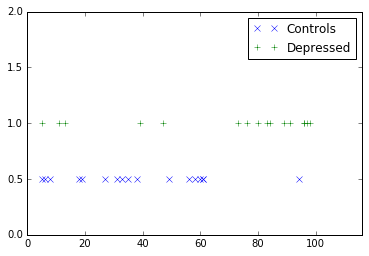

In [8]:
# Let's check out our results

#all values positive --> if 0 then both methods agree 100%
print('Sum of method differences for controls is:', np.mean(np.abs(comp_D[:,0] - comp_D[:,1]))) 
print('Sum of method differences for depressed is:', np.mean(np.abs(comp_C[:,0] - comp_C[:,1])))

# now plot group differences
plt.plot(comp_C[:,0], len(comp_C[:,0]) * [0.5], "x", label = 'Controls')
plt.plot(comp_D[:,0], len(comp_D[:,0]) * [1], "+", label = 'Depressed')
plt.axis([0, 116,0,2])
plt.legend()
plt.show()


In [9]:
# Robust against threshold choice? Generate 100 thresholds, look at avg connected component number for each

bin_C = np.ones(dataC.shape)   
bin_D = np.ones(dataD.shape)

ind_comp_C = np.zeros(dataC.shape[0])
ind_comp_D = np.zeros(dataD.shape[0])   
avg_comp   = np.zeros([100, 2])            # column 1: controls; Column 2: depressed

thresh = 0.025                             # initial threshold; we'll move it in increments

for i in range(0, 100): 
    sub_threshold_indices_C = np.abs(dataC) < (thresh * i)  
    sub_threshold_indices_D = np.abs(dataD) < (thresh * i)
    bin_C[sub_threshold_indices_C] = 0  
    bin_D[sub_threshold_indices_D] = 0 
    
    for subj in range(0, dataC.shape[0]):
        ind_comp_C[subj] = graphs.connected_components(bin_C[subj,:,:])[0] 
    for subj in range(0, dataD.shape[0]):
        ind_comp_D[subj] = graphs.connected_components(bin_D[subj,:,:])[0] 
    avg_comp[i,:] = [np.mean(ind_comp_C), np.mean(ind_comp_D)]
      

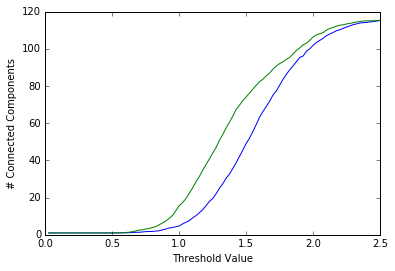

In [10]:
plt.plot(np.linspace(0.025, 2.5, 100), avg_comp[:,0])
plt.plot(np.linspace(0.025, 2.5, 100), avg_comp[:,1])
plt.ylabel('# Connected Components')
plt.xlabel('Threshold Value')
plt.show()

As we can see, the number of connected components varies dramatically as a function of our threshold. This often makes analyses based off of thresholding A) harder to replicate and B) more prone to somehow getting nice results (:thinking emoji:) by introducing more degrees of freedom into experimental design.

Thankfully, there are a couple approaches that can be taken to mitigate the issue here:
   * Introduce standards.
   * Consider how the graph structure changes as a function of the threshold. Examine graph properties at *all* possible thresholds and study the persistence of various structures as we change our "lens". This approach is called persistent homology and is another cool/painful area for those interested.
   * Use another metric (Ashton, you're up).

## Metric 3 - Modularity

Intuitively, modularity quantitatively measures how much we can divide a graph into modules/groups/clusters. It holds a vlaue between -1 and 1, in which a large value (1) means that the graph is densely connected within modules, and sparsely connected between modules. A low value (-1) means that entire graph highly connected, and we cannot really split it into groups (connected components).

More formally, We want to subdivide the network into
nonoverlapping groups of nodes in a way that maximizes the number of
within-group edges, and minimizes the number of between-group edges.
The modularity is a statistic that quantifies the degree to which the
network may be subdivided into such clearly delineated groups.

The Louvain algorithm is a fast and accurate community detection
algorithm:
1. Assign each node to its own community i.
2. Calculate modularity if remove node from its community i
3. Calculate modularity if add node to every neighboring community j
4. Put node into community that results in highest modularity increase. If no increase possible, node stays in its own community i.
5. Apply Steps 1-4 for all nodes in graph repeatedly, until no more modularity increase possible.
6. Merge all nodes in one community into a new node. Incoming edge weights are summed.
7. Repeat Steps 1-6 with graph of new nodes. 

The implementation of this algorithm (modularity_louvain_und_sign) can be found in modularity.py. Given a connection matrix, this particular implementation returns the grouped members for each module, as well as the modularity of the network. Here we are only interested in the modularity value.

In [11]:
from modularity import modularity_louvain_und_sign
#loop over each individual's data, and put modularity value into a list
modularity_C = [modularity_louvain_und_sign(dataC[i])[1] for i in range(len(dataC))]
modularity_D = [modularity_louvain_und_sign(dataD[i])[1] for i in range(len(dataD))]

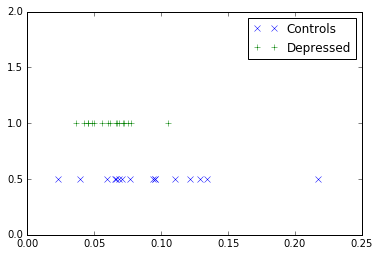

In [12]:
# Visualize our modularity measures between groups
plt.plot(modularity_D, len(modularity_D) * [0.5], "x", label = 'Controls')
plt.plot(modularity_C, len(modularity_C) * [1], "+", label = 'Depressed')
plt.axis([0, 0.25, 0,2])
plt.legend()
plt.show()
#Note: the y-axis here does not mean anything. 
#It is merely introduced to separate out and visualize the controls and depressed modularity data.

Now that we have a list of modularities for controls, and a list of modularities for depressed individuals, how do we know whether they are different? Can we just compare the average modularities? We will see how to test for significant difference in the statistics section!

# Hypothesis Testing in fMRI data

#### Goal : 

The nobel prize winning physicist once aptly stated that "rigor and clarity are not synonymous". Keeping this in mind the intended emphasis of this notebook is clarity. It *is not* our goal to give a rigorous mathematical presentation of various statistical tests and methods that can be used to test connectivity levels between different brain types;however,it *is* our goal to provide clarity on how one could test whether or not there is a "significant difference" (used here in a very colloqiual sense) between the depressed brains and the not depressed brains. That is not to say the former is not important. We strongly reccomend taking a rigorous class in mathematical statisitcs such as Stat 135. However we choose not to delve into the mathematics here because we feel it is first important to understand ,in a very concrete way, *why* taking such a class could be interesting and useful.

#### Abstraction: 

Often times when trying to solve a particular problem with data IRL it is important to be able to abstract away the problem from the particular to the general. Case and point: If we were the first researchers studying links between connectivity of the brain and depression, googling: "How to tell the difference between depressed brains and not depressed brain" would likely not be very helpful. We are on the cutting edge! If google knew the answer to this question then our funding would likely be in jeopardy. However if we were to abstract the problem away from specific, and enter a query such as: "statistical test to determine whether or not 2 different samples were pulled from the same distribution" then ... we would be in buisness. However knowing to enter such a query requires a certain amount of understanding; in particular  knowing to enter such a query requires us to have the ability to **think probabalistically**. 

In short, the main goal of this notebook is to provide a concrete example of how to think probabilistically and computationally to solve a real-world problem. In particular we want to provide the reader with an example of how we can model data with random variables and then draw inferences from that model.

Part of thinking "computationally"(at least in the context of dealing with data) involves the ability to use computers to get an intuition about the structure of the data. A big part of this intuition comes in the form of visualization. Thus we sill start our analysis by visualizing the data.

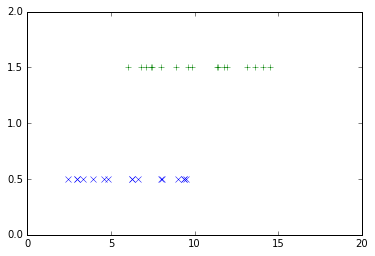

In [13]:
## Visualize data 
depressed = np.random.uniform(2,10,16)
happy = np.random.uniform(5,15,17)

plt.plot(depressed, len(depressed) * [0.5], "x")
plt.plot(happy, len(happy) * [1.5], "+")
plt.axis([0, 20,0,2])
plt.show()

#### Model:

Visually we are able to tell that there is definitiely a difference between the two groups. However if we want to try and make this difference a bit more precise. This is where knowing how to think probabalistically becomes very important.

Our given data is the conectivity statistics for $n$ brains, which we will denote $B_1, \ldots, B_n$. Wherein there is some set of indeces $D$ corresponding to depressed brains, and some set of indeces $H$ corresponding to not depressed (happy) brains. What we want to test is whether or not the connectivity of the depressed brains and happy brains are drawn from the same distribution i.e. $B_1,\ldots,B_n \sim \mathbb{B}$ or if they are drawn from fundamentally different distributions i.e. $B_i \sim \mathbb{D} \ \ \forall i \in D$ and $B_i \sim \mathbb{H} \ \ \forall i \in H$.

###### Quick Overview To R.V.s and Discrete Probability Distributions (If you need a review or a quick overview) 
https://www.stat.berkeley.edu/~stark/SticiGui/Text/randomVariables.htm




At this point I really want to emphasize that everything shown above is THE MOST IMPORTANT PART OF THIS NOTEBOOK. Because IRL now would be the time to start some frantic googling: http://bfy.tw/DylF to try and figure out a good way to test the differences in brain. If you are able to do what I have described above, namely think probabilistically and computationally you have picked up the main point of this portion of the presentation. That is not to say that the following portion of the notebook is not important. It is just the analysis that follows presents an outline of some of the take home messages, one would have gleamed after a lot of time thinking about the problem. In other words DO NOT FEEL BAD IF YOU ARE NOT ABLE TO FOLLOW THE NEXT SESSION. Especially if you are a biologist since the folowing presents a certain thought process that takes a lot of time to develop -- time that you may not have put in if you haven't taken a lot of more theoretical classes.


![title](imgs/math_ahead.png)

At this point one idea is to try and model the conditional probability that we observe the current variation in brains given they were drawn from different distributions i.e.

$$
\mathbb{P}(B_1,\ldots, B_n | B_i \sim \mathbb{D} \ \ \forall i \in D, B_i \sim \mathbb{H} \ \ \forall i \in H )
$$

The idea being if this probability is high then we have strong evidence suggesting there is a difference in connectivity levels of depressed and happy brains. However using such a model requires prior knowledge of the distributions $\mathbb{D}$ and $\mathbb{H}$. Knowledge that we do not neccessarily have *a priori*. Keeping this in mind let us consider the second natural approach to try and guage whether or not there is a difference between happy and depressed brains. Namely:

$$
\mathbb{P}(B_1,\ldots, B_n | B_i \sim \mathbb{B} \ \ \forall i ).
$$

This approach seems to be superior to the previous one in the sense that it only deals with one unknown distribution rather than $2$. Furthermore with this framing of the problem we should be able to rank all of the brains from most connected to least connected -- namely $R(B_1), ...,R(B_i)$ and calculate the probability the rankings appear the way they do assuming $B_i \sim \mathbb{B} \ \ \forall i$. More rigorously we will look at

$$
\mathbb{P}(R(B_1),\ldots, R(B_n) | B_i \sim \mathbb{B} \ \ \forall i ).
$$

where $R$ is a function that maps the test statistic to its ranking. This seems to have promise since once we look at the rankings we are somehow overcoming the problem of the unknown distribution. However we are not quite there. In particular in it's hard to see how this calculation bears any practical significance given as n grows very large the probablity that the rankings take any specific form tends towards $0$. Thus all the probabilities are low. One response is to consider the rank-sum of all of the depressed brains and calculate what the probability of seeing a rank-sum as extreme or more extreme then the computed rank-sum. More precisely

$$
\mathbb{P}(\sum_{i \in D} R(B_i) \ | \ B_i \sim \mathbb{B} \ \ \forall i ).
$$

Here we are measuring the probability that a randomly selected subset of size $|D|$ from an original set of size $|B|$ has rank sum as extrme as $sum_{i \in D} R(B_i)$. Indeed, we can calculate the distribution of the rank sum of a subset of size $|D|$ from a superset of size $|S|$ from first principles and calculate $ \mathbb{P}(\sum_{i \in D} R(B_i) \ | \ B_i \sim \mathbb{B} \ \ \forall i )$. This is in fact called the Wilcoxon Rank sum test; and there is code for it in python !

In [14]:
# Wilcoxon rank sum test
# Reference https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html
test_statistic,p_value= stats.ranksums(depressed,happy)
print("-------------------------------------------------------------------------------------------------------------")
print("The probability we observe a rank sum this extreme given the brains were drawn from the same distribution is:")
print(p_value)
print("-------------------------------------------------------------------------------------------------------------")
print("In other words if the brains were drawn from the same distribution we would expect to see a rank sum this extreme")
print(str(p_value*100) + "% of the time")
print("-------------------------------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------------------------------
The probability we observe a rank sum this extreme given the brains were drawn from the same distribution is:
0.000808006374001
-------------------------------------------------------------------------------------------------------------
In other words if the brains were drawn from the same distribution we would expect to see a rank sum this extreme
0.0808006374001% of the time
-------------------------------------------------------------------------------------------------------------


## Take Home Excercise for fun

In the real world we would just, google it as is done above. But it can be a good excercise to see if you can code this in python. Below I have some skeleton python code. 

#### Notes about the skeleton
Below I use an iterator in(thats what combinations returns).  An iterator is an object in python that CAN be iterated over; but CANNOT be"accessed" like a list. In python this tends to give certain performaince 
benefits. See : https://stackoverflow.com/questions/628903/performance-advantages-to-iterators


In [15]:
def get_rank_distribution(num_small ,num_total):
    """
    Returns function that evaluates p-value given sum_statisitc
    from num_small,num_total distribution
    """
    assert (num_small < num_total),"num small must be less than num total"
    num_sums = int(round(special.binom(num_total,num_small)))
    vals = np.zeros(num_sums)
    i = 0
    # Note even though we are working in python, the rankings are starting with 1
    for combination in combinations(np.arange(num_total),num_small):
        vals[i] = sum(combination)
        i += 1
    vals = np.sort(vals)         
    return vals


def get_p_val_func(rank_distribution):
    """
    Returns function that computes the p-value of the observed sum from distribution
    of vals
    """
    def p_val_func(obs_sum):
        return
    return 

def compute_rank_sum_stat(shorter_subset,total_set):
    """
    Compute rank sum of smaller population
    """
    return 

def compute_rank_of(x,sorted_lst):
    """
    Given x that lives in sorted list. This function finds its ranking
    """
    ix = x in sorted_list #np.isin(sorted_lst,x)
    loc = np.where(ix)*1
    tuple_to_num = lambda x : x[0] 
    # Note : ranke is currently zero indexed
    rank = tuple_to_num(loc) 
    return rank[0]


def compute_p_value(shorter_subset,total_set):
    """ 
    Compute p-value using rank Wilcoxon Rank Sum statistic to see it their is
    a difference between the connectivity levels for depressed and happy brains 
    """
    rank_distribution = get_rank_distribution(shorter_subset ,total_set)
    p_val_func = get_p_val_func(rank_distribution)
    obs_sum = compute_rank_sum_stat(shorter_subset,total_set)
    return p_val_func(obs_sum)

assert compute_rank_of(2,np.arange(4)) == 2
assert np.allclose(get_rank_distribution(1,3), np.array([0,1,2]) )


AttributeError: module 'numpy' has no attribute 'isin'

### If you are interested here are some additional articles/sources

If you know what the two sample non-parametric bootstrap you may find this post interesting <br> 
https://stats.stackexchange.com/questions/61787/can-bootstrap-be-used-to-replace-non-parametric-tests?rq=1

If you now about complexity and Natural question how do we do this for large sample sizes? Answer is define clever statisitic that is asymptotically Normal. First page of below note: <br>
http://sites.stat.psu.edu/~drh20/asymp/fall2003/lectures/pages63to75.pdf

If you are interested in learning more about iterators in python. You should read
the wiki on streams <br>
https://en.wikipedia.org/wiki/Stream_(computing) 

If you are interested in real research: <br>
https://www.scientificamerican.com/article/brain-imaging-identifies-different-types-of-depression/